Code to view the pulses kept alongside those cut away.

In [1]:
import sys
import time
import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # http://www.numpy.org/
import tekwfm
import os
from os.path import exists
from scipy import signal
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.special import gamma
import matplotlib.cm as cm
from collections import Counter

import gc
import re
import tempfile
from collections import defaultdict, namedtuple
from pathlib import Path
import pandas as pd

doVerbose = False

In [2]:
#import the wfm file
#filename_wfm = "PMT4_WFM_DR/220126_darkrate_1800_10000_2_off"
filename_wfm = "PMT7_rawdata/020226_darkrate_1950_10000_2_on"
#import the cleaned file and make data frame
#clean_csv = pd.read_csv("PMT4_CLEAN_11SIG_DR/220126_darkrate_1800_10000_2_off_processed_threshold11_cleaned.csv")
clean_csv = pd.read_csv("PMT7_Cleaned_TTaboveVaried/020226_darkrate_1950_10000_2_on_processed_threshold27_cleaned.csv")
#import the processed file
#processed_csv = pd.read_csv("PMT4_11SIGMA_PROC_DR/220126_darkrate_1800_10000_2_off_processed_threshold11.csv")
processed_csv = pd.read_csv("PMT7_Processed_27sig/020226_darkrate_1950_10000_2_on_processed_threshold27.csv")
#choose number of events to be seen and starting event (first event is event 0)

startEvent = 0
nEvents = 100

n = 27     #threshold for pulse to pass
BASELINE_SIGMA_CUT = 15     #currently baseline cutting on mu + 15sigma


volts, tstart, tscale, tfrac, tdatefrac, tdate = tekwfm.read_wfm(filename_wfm+".wfm")
if doVerbose:
    print('>>>>', volts, tstart, tscale, tfrac, tdatefrac, tdate)

samples = volts.shape

print(len(volts))
print(tscale)
print('samples', samples[0])
tstop = samples[0]*tscale+tstart
sampleTimes = [tstart+x*tscale for x in range(samples[0])]
negVolts = [volts[:, event] for event in range(startEvent, startEvent + nEvents)] # all events, array of array of voltages
tempVolts = -volts


"""variables which can be changed"""
baseline_end_frac = 0.15
amplitude_start_frac = 0
amplitude_end_frac = 0.6
pulse_end_frac = 0.99


FileNotFoundError: [Errno 2] No such file or directory: 'PMT7_Cleaned_TTaboveVaried/020226_darkrate_1950_10000_2_on_processed_threshold27_cleaned.csv'

Fit completed max 3 iterations.
μ_baseline_SD  = 0.451 mV
σ_baseline_SD  = 0.039 mV
Baseline cut (μ + 15σ) = 1.031 mV


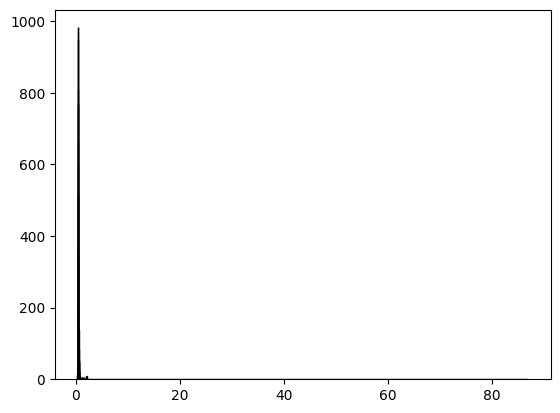

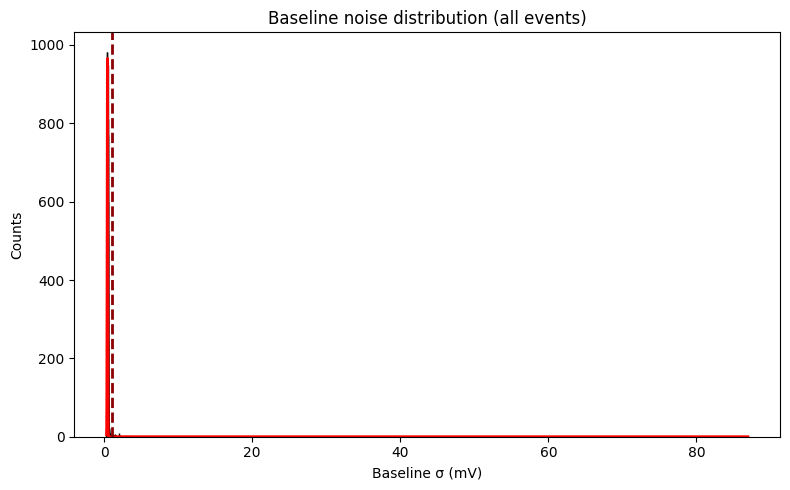

In [ ]:
sigma_b_array_mV = processed_csv["sd_baseline"].to_numpy() * 1e3
'''
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

bins = int((sigma_b_array_mV.max() - sigma_b_array_mV.min()) / 0.01)
counts, edges = np.histogram(sigma_b_array_mV, bins=bins)
centers = 0.5 * (edges[1:] + edges[:-1])

p0 = [counts.max(), centers.mean(), centers.std()]
popt, pcov = curve_fit(gaussian, centers, counts, p0=p0)

mu_sb, sigma_sb = popt[1], popt[2]
'''
def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)
sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.01) #chosen 1 bin = 0.01mV
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away
fit_mask = (bin_centers >=0) & (bin_centers <=2)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]
X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]
final_popt = None
final_pcov = None
final_mask = None
for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_sb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_sb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    sb_fit_full = gaussian_sb(bin_centers, *final_popt)
    mu_sb = final_popt[1]
    sigma_sb = final_popt[2]
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])




BASELINE_CUT_MV = mu_sb + BASELINE_SIGMA_CUT * sigma_sb

print(f"μ_baseline_SD  = {mu_sb:.3f} mV")
print(f"σ_baseline_SD  = {sigma_sb:.3f} mV")
print(f"Baseline cut (μ + 15σ) = {BASELINE_CUT_MV:.3f} mV")


# Plot distribution
plt.figure(figsize=(8,5))
plt.hist(sigma_b_array_mV, bins=bins, color="skyblue", edgecolor="black")
plt.plot(bin_centers, gaussian_sb(bin_centers, *popt), "r", lw=2)
plt.axvline(BASELINE_CUT_MV, color="darkred", ls="--", lw=2)
plt.xlim(0, 10)
plt.xlabel("Baseline σ (mV)")
plt.ylabel("Counts")
plt.title("Baseline noise distribution (all events)")
plt.tight_layout()
plt.show()

In [ ]:

def calcbaseline(tempVolt, samples):
    baseline = tempVolt[:int(baseline_end_frac * samples[0])]
    mean_b = baseline.mean()
    sigma_b = baseline.std(ddof=1)
    corrected = tempVolt - mean_b
    return mean_b, sigma_b, corrected



def calcamplitude(corrected_tempVolt, samples):
    #amplitude_voltages = corrected_tempVolt[int(amplitude_start_frac*samples[0]):int(amplitude_end_frac*samples[0])]
    threshold = 5 * sigma_b
    if threshold > 0.003 * 1e3 :
        min_height = 5 * sigma_b
    else:
        min_height = 0.003 * 1e3
    #min_height = 0.003
    min_separation = int(0.05*samples[0]) # have changed from 0.04
    prominance = 0.01 * 1e3# have changed from 0.025
    #peaks, _ = find_peaks(amplitude_voltages, height=min_height, distance=min_separation, prominence=prominance)
    peaks, properties = find_peaks(corrected_tempVolt, height=min_height, distance=min_separation, prominence=prominance)
    number_of_peaks = len(peaks)
    if len(peaks) > 0:
        amplitude = corrected_tempVolt[peaks[0]]
        #first_peak_index = peaks[0] + int(amplitude_start_frac*samples[0])
        first_peak_index = peaks[0]
        first_peak_time = sampleTimes[first_peak_index]

    else:

        amplitude = np.max(corrected_tempVolt)
        peak_index = np.argmax(corrected_tempVolt)
        first_peak_index = peak_index
        first_peak_time = sampleTimes[first_peak_index]
    #if amplitude > 0.005:
      # number_of_peaks = 1
        number_of_peaks = 1

    return amplitude, first_peak_index, first_peak_time, number_of_peaks, peaks


def total_time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b, n):
    threshold = n * sigma_b
    if max(corrected_tempVolt) <= threshold:
        return None
    total_time = 0.0

    for i in range(len(corrected_tempVolt) - 1):
        v1 = corrected_tempVolt[i]
        v2 = corrected_tempVolt[i + 1]
        t1 = sampleTimes[i]
        t2 = sampleTimes[i + 1]
        dt = t2 - t1

        # Entire segment above threshold
        if v1 > threshold and v2 > threshold:
            total_time += dt

        # Rising through threshold
        elif v1 <= threshold and v2 > threshold:
            frac = (threshold - v1) / (v2 - v1)
            total_time += (1 - frac) * dt

        # Falling through threshold
        elif v1 > threshold and v2 <= threshold:
            frac = (threshold - v1) / (v2 - v1)
            total_time += frac * dt

        # Else: fully below threshold → add nothing

    return total_time if total_time > 0 else None

def calc_time_above_3sigma(corrected, times, sigma_b, mean_b, first_peak_index):
    threshold = mean_b + 3*sigma_b

    i = first_peak_index
    while i > 0 and corrected[i] > threshold:
        i -= 1
    # If we hit the boundary and are STILL above threshold → no crossing
    if i == 0 and corrected[i] > threshold:
        return None, None, None
    # Interpolate only if we actually crossed between i and i+1
    y1, y2 = corrected[i], corrected[i+1]
    x1, x2 = times[i], times[i+1]
    # Ensure interpolation makes physical sense
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):  
        return None, None, None
    first_3sigma_cross = x1 + frac * (x2 - x1)

    j = first_peak_index
    while j < len(corrected)-1 and corrected[j] > threshold:
        j += 1
    if j == len(corrected)-1 and corrected[j] > threshold:
        return None, None, None
    y1, y2 = corrected[j-1], corrected[j]
    x1, x2 = times[j-1], times[j]
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):
        return None, None, None
    second_3sigma_cross = x1 + frac * (x2 - x1)

    time_above_3sigma = second_3sigma_cross - first_3sigma_cross
    if time_above_3sigma <= 0:
        return None, None, None

    return time_above_3sigma, first_3sigma_cross, second_3sigma_cross

def time_index(first_3sigma_cross, sampleTimes):
    if first_3sigma_cross is None:
        return len(sampleTimes) - 1
    else:
        time_difference = np.abs(np.array(sampleTimes) - first_3sigma_cross)
        closest_index = np.argmin(time_difference)
        return closest_index
        
#integrate a single event
def single_charge_integral(corrected_tempVolt, sampleTimes, closest_index):
    # define bound 1 and 2
    bound_1 = closest_index
    bound_2 = int(pulse_end_frac*len(corrected_tempVolt))
    integral_voltages = corrected_tempVolt[bound_1:bound_2]
    time_slice = sampleTimes[bound_1:bound_2]
    single_integral = integrate.trapezoid(integral_voltages, x=time_slice)
    #return a single number for the integral of one event
    return single_integral

def correcting_tempVolts(tempVolts, mean_b):
    corrected_tempVolts = []
    for i, tempVolt in enumerate(tempVolts):
        corrected = tempVolt - mean_b[i]
        corrected_tempVolts.append(corrected)
    return corrected_tempVolts

mean_b_array = []
sigma_b_array = []
corrected_tempVolts = []
all_amplitudes = []
all_peak_times = []
all_peak_indices = []
all_FWHM = []
all_t1 = []
all_t2 = []
all_time_above_thresh = []
all_total_time_above = []
all_first_crossing = []
all_second_crossing = []
all_tabove_3sig = []
all_first_t_3sig = []
all_second_t_3sig = []
all_closest_indices = []
all_integrals = []
all_number_of_peaks = []

for tempVolt in tempVolts:
    mean_b, sigma_b, corrected_tempVolt = calcbaseline(tempVolt, samples)
    mean_b_array.append(mean_b)
    sigma_b_array.append(sigma_b)
    corrected_tempVolts.append(corrected_tempVolt)

mean_b_array = np.array(mean_b_array) * 1e3
sigma_b_array = np.array(sigma_b_array) * 1e3
corrected_tempVolts = np.array(corrected_tempVolts) * 1e3
'''
def integrate_pulse(corrected, start_idx):
    end = int(pulse_end_frac * samples)
    return integrate.trapezoid(corrected[start_idx:end],
                               x=sampleTimes[start_idx:end])
'''


'\ndef integrate_pulse(corrected, start_idx):\n    end = int(pulse_end_frac * samples)\n    return integrate.trapezoid(corrected[start_idx:end],\n                               x=sampleTimes[start_idx:end])\n'

In [ ]:

passed_events = set(clean_csv["event_id"].astype(int))
bad_events = []
good_events = []



for event in range(startEvent, startEvent + nEvents):
    if event in passed_events:
        good_events.append(event)
    else:
        bad_events.append(event)

print("Bad events:", bad_events)
print("Good events:", good_events)



'''
def get_rejection_reason(event):
    row = processed_csv[processed_csv["event_id"] == event]
    if row.empty:
        return "event not found", None

    sigma_b_mv = row.iloc[0]["sd_baseline"] * 1e3

    if sigma_b_mv > BASELINE_CUT_MV:
        return "baseline cut", sigma_b_mv

    if row.iloc[0]["time_above_threshold"] <= 0:
        return "time_above_threshold <= 0", sigma_b_mv

    return "other cut", sigma_b_mv
'''

Bad events: [7, 8, 23, 25, 39, 60, 65, 88, 98]
Good events: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99]


'\ndef get_rejection_reason(event):\n    row = processed_csv[processed_csv["event_id"] == event]\n    if row.empty:\n        return "event not found", None\n\n    sigma_b_mv = row.iloc[0]["sd_baseline"] * 1e3\n\n    if sigma_b_mv > BASELINE_CUT_MV:\n        return "baseline cut", sigma_b_mv\n\n    if row.iloc[0]["time_above_threshold"] <= 0:\n        return "time_above_threshold <= 0", sigma_b_mv\n\n    return "other cut", sigma_b_mv\n'

In [ ]:

def annotate_pulse(ax, sampleTimes, corrected,
                   mean_b, sigma_b,
                   peak_idx, amplitude,
                   first_3sigma_cross,
                   peaks):

    times = np.array(sampleTimes)
    times_ns = times * 1e9
    volts_mv = corrected * 1e3

    ax.axhline(3*sigma_b*1e3, color='red', linestyle=':', label='3σ')
    ax.axhline(1*sigma_b*1e3, color='orange', linestyle='--', label='Baseline s.d.')
    ax.axhline(n*sigma_b*1e3, color='blue', linestyle='--', label=f'{n}σ')
    ax.axvline(times_ns[peak_idx], color='green', linestyle=':', label='Peak')
    ax.axhline(amplitude*1e3, color='green', linestyle=':', label='Peak amplitude')

    #for p in peaks:
        #ax.axvline(times_ns[p], color='green', linestyle=':', alpha=0.5)

    if first_3sigma_cross is not None:
        ax.axvline(first_3sigma_cross*1e9,
                   color='red',
                   linestyle=':',
                   label='3σ crossing')

    x_start = times_ns[0]
    x_end = times_ns[int(0.15 * len(times))]

    ax.axvspan(
        x_start,
        x_end,
        color='blue',
        alpha=0.05,
        label='Baseline region'
    )

    if first_3sigma_cross is not None:
        start_idx = np.searchsorted(times, first_3sigma_cross)
    else:
        start_idx = peak_idx

    end_idx = int(pulse_end_frac * len(times))

    ax.fill_between(
        times_ns[start_idx:end_idx],
        volts_mv[start_idx:end_idx],
        0.0,
        color='magenta',
        alpha=0.2,
        label='Integration region'
    )

    ax.set_xlim(-20, 80)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),
              fontsize=8, loc='upper right')


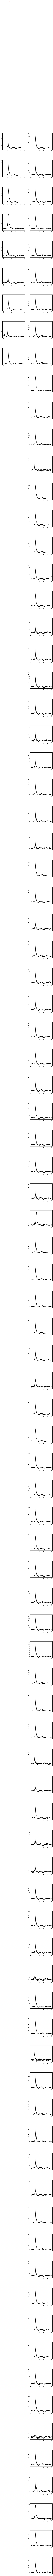

In [ ]:
n_bad = len(bad_events)
n_good = len(good_events)
n_rows = max(n_bad, n_good)

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 6*n_rows))

# Fix shape if only one row
if n_rows == 1:
    axes = np.array([axes])

'''
# bad events
for i, event in enumerate(bad_events):
    event_index = event - startEvent
    tempVolt = tempVolts[:, event]
    ax = axes[i, 0]


    amplitude, first_peak_index, first_peak_time, number_of_peaks, peaks = calcamplitude(corrected_tempVolt, samples)
    time_above_3sigma, first_3sigma_cross, second_3sigma_cross = calc_time_above_3sigma(corrected_tempVolt, sampleTimes, sigma_b_array[event_index], mean_b_array[event_index], first_peak_index)
    closest_index = time_index(first_3sigma_cross, sampleTimes)
    single_integral = single_charge_integral(corrected_tempVolt, sampleTimes, closest_index)
    total_time = total_time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b_array[event_index])


    ax.plot(
        np.array(sampleTimes) * 1e9,
        corrected_tempVolt * 1e3,
        color='black'
    )


    if first_3sigma_cross is not None:
        full_annotations(
                corrected_tempVolt,
                sampleTimes,
                mean_b_array[event_index],
                sigma_b_array[event_index],
                first_peak_index,
                event_index,
                amplitude,
                first_3sigma_cross,
                peaks
            )
        
    if first_3sigma_cross is not None:
            closest_index = time_index(first_3sigma_cross, sampleTimes)
            single_integral = single_charge_integral(
            corrected_tempVolt,
            sampleTimes,
            closest_index
            )
    else:
        closest_index = None
        single_integral = None

   # reason, sigma_b_mv = get_rejection_reason(event)

    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel('Oscilloscope Timebase (ns)', fontsize=14)
    ax.set_xlim(-20, 80)
    ax.set_ylabel('Voltage (mV)', fontsize=14)
    ax.set_ylim(-2, 25)
    
    ax.set_title(f"Event {event} — FAILED", fontsize=12)
    ax.text(
    0.5, -0.28,
    f"Rejected reason: {reason}\n"
    f"Baseline σ = {sigma_b_mv:.2f} mV\n"
    f"Baseline cut = {BASELINE_CUT_MV:.2f} mV",
    transform=ax.transAxes,
    ha='center',
    va='top',
    fontsize=11,
    color='darkred',
    wrap=True
)

    del tempVolt


'''
for i, event in enumerate(bad_events):
    tempVolt = tempVolts[:, event]
    ax = axes[i, 0]

    ax.plot(
        np.array(sampleTimes) * 1e9,
        tempVolt * 1e3,
        color='black'
    )

# good events
for i, event in enumerate(good_events):

    tempVolt = tempVolts[:, event]
    ax = axes[i, 1]
    
    ax.plot(
        np.array(sampleTimes) * 1e9,
        tempVolt * 1e3,
        color='black'
    )


for i in range(n_rows):
    if i >= n_bad:
        axes[i, 0].axis('off')
    if i >= n_good:
        axes[i, 1].axis('off')


fig.text(0.25, 0.985, "BAD pulses (Failed the cuts)", ha='center', va='top',
         fontsize=16, color='red')

fig.text(0.75, 0.985, "GOOD pulses (Passed the cuts)", ha='center', va='top',
         fontsize=16, color='green')

plt.subplots_adjust(top=0.94, hspace=0.6)
plt.show()